In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20%_Loans_12_feat_scaled_verified.csv')
data.head(5)

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,pub_rec,term,grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,loan_status_bin
0,-0.878145,-0.413899,-0.990786,0.519783,0.374250,0.675057,-0.377827,0.693847,0.799133,-0.666132,-0.016121,1.079578,-0.007897,-0.007897,-0.35599,-0.860345,1.0
1,1.704364,-1.133315,1.219066,0.791081,1.229373,0.920280,-0.377827,0.693847,-0.457283,0.605806,-0.016121,1.079578,-0.007897,-0.007897,-0.35599,-0.860345,1.0
2,0.741172,0.917942,0.662736,-0.115162,0.897101,-0.305835,-0.377827,0.693847,0.799133,0.097031,-0.016121,-0.926288,-0.007897,-0.007897,-0.35599,1.162325,0.0
3,0.609947,-0.413899,0.358482,0.303104,0.273989,2.146396,-0.377827,0.693847,0.799133,1.114582,-0.016121,1.079578,-0.007897,-0.007897,-0.35599,-0.860345,1.0
4,-0.193150,-0.771763,-0.401572,-0.481144,0.102467,-0.060612,1.178730,0.693847,-0.457283,1.114582,-0.016121,-0.926288,-0.007897,-0.007897,-0.35599,1.162325,0.0


In [4]:
data.shape

(96217, 17)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    56185
0.0    40032
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(96217, 16)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.60340885 0.60294118 0.59891909 0.60718183 0.60395988]
0.6032821665017807


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[ 9759, 30273],
       [ 7898, 48287]])

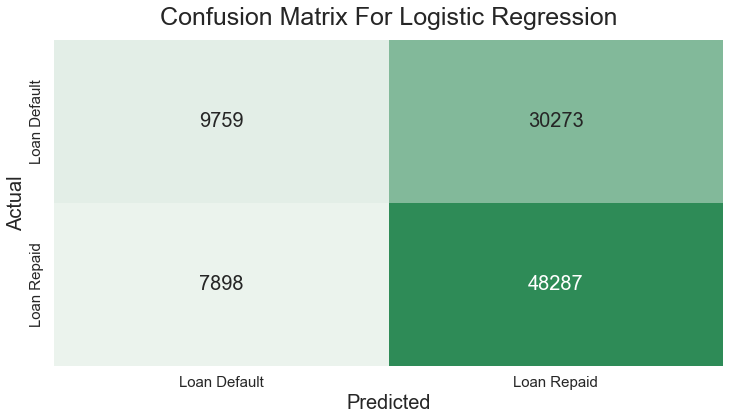

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.6032821642745045

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

48287
30273
7898
9759
0.6032821642745045


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 58% chance of pickkng a good loan

1.0    56185
0.0    40032
Name: loan_status_bin, dtype: int64

0.5839404679006829


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.6146512219959267

In [17]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [18]:
y_pred_prob

array([[0.36666134, 0.63333866],
       [0.3660152 , 0.6339848 ],
       [0.59002013, 0.40997987],
       ...,
       [0.30277228, 0.69722772],
       [0.35143499, 0.64856501],
       [0.29942736, 0.70057264]])

In [51]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[39906,   126],
       [55656,   529]])

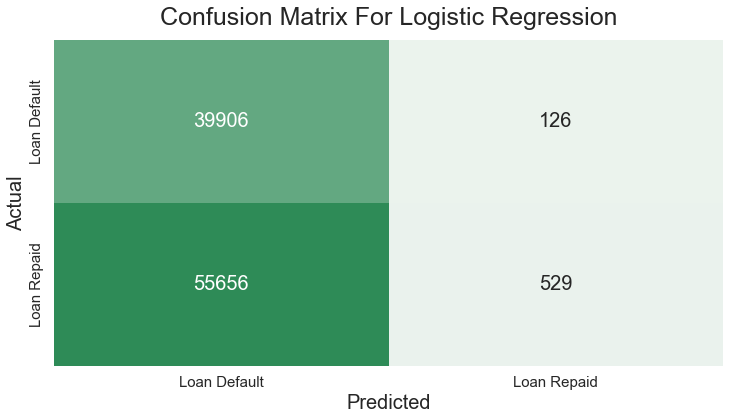

In [53]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [54]:
accuracy_score(y, y_pred_success)

0.42024798112599643

In [55]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

529
126
55656
39906
0.42024798112599643


In [56]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8076335877862595

In [31]:
## Next question. what was characteristic of the 126 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [58]:
unscaled = pd.read_csv('../../Data/20%_Loans_12_feat_unscaled_verified.csv')
unscaled.head(5)

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,loan_status_bin,pub_rec,term,grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
0,10400.0,22.45,289.91,104433.0,25.37,695.0,1.0,0.0,1,2,4,0,1,0,0,0,0
1,35000.0,20.50,937.06,120000.0,35.69,700.0,1.0,0.0,1,1,9,0,1,0,0,0,0
2,25825.0,26.06,774.14,68000.0,31.68,675.0,0.0,0.0,1,2,7,0,0,0,0,0,1
3,24575.0,22.45,685.04,92000.0,24.16,725.0,1.0,0.0,1,2,11,0,1,0,0,0,0
4,16925.0,21.48,462.46,47000.0,22.09,680.0,0.0,1.0,1,1,11,0,0,0,0,0,1


In [59]:
unscaled.shape

(96217, 17)

In [60]:
data = pd.read_csv('../../Data/20%_Loans_12_feat_scaled_verified.csv')
data.head(5)

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,pub_rec,term,grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,loan_status_bin
0,-0.878145,-0.413899,-0.990786,0.519783,0.374250,0.675057,-0.377827,0.693847,0.799133,-0.666132,-0.016121,1.079578,-0.007897,-0.007897,-0.35599,-0.860345,1.0
1,1.704364,-1.133315,1.219066,0.791081,1.229373,0.920280,-0.377827,0.693847,-0.457283,0.605806,-0.016121,1.079578,-0.007897,-0.007897,-0.35599,-0.860345,1.0
2,0.741172,0.917942,0.662736,-0.115162,0.897101,-0.305835,-0.377827,0.693847,0.799133,0.097031,-0.016121,-0.926288,-0.007897,-0.007897,-0.35599,1.162325,0.0
3,0.609947,-0.413899,0.358482,0.303104,0.273989,2.146396,-0.377827,0.693847,0.799133,1.114582,-0.016121,1.079578,-0.007897,-0.007897,-0.35599,-0.860345,1.0
4,-0.193150,-0.771763,-0.401572,-0.481144,0.102467,-0.060612,1.178730,0.693847,-0.457283,1.114582,-0.016121,-0.926288,-0.007897,-0.007897,-0.35599,1.162325,0.0


In [61]:
data.shape

(96217, 17)

In [62]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    56185
0.0    40032
Name: loan_status_bin, dtype: int64

In [63]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(96217, 16)

In [64]:
y = data['loan_status_bin']

In [65]:
lr2 = LogisticRegression()

In [66]:
lr2.fit(X,y)

LogisticRegression()

In [67]:
lr2.predict_proba(X)

array([[0.36568848, 0.63431152],
       [0.36134283, 0.63865717],
       [0.5847    , 0.4153    ],
       ...,
       [0.29936972, 0.70063028],
       [0.35335002, 0.64664998],
       [0.2997666 , 0.7002334 ]])

In [68]:
lr2.predict_proba(X)[:, 1]

array([0.63431152, 0.63865717, 0.4153    , ..., 0.70063028, 0.64664998,
       0.7002334 ])

In [69]:
lr2.predict(X)

array([1., 1., 0., ..., 1., 1., 1.])

In [71]:
unscaled['Successful Probability'] = pd.Series(lr2.predict_proba(X)[:, 1])
unscaled

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,loan_status_bin,pub_rec,term,grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,Successful Probability
0,10400.0,22.45,289.91,104433.0,25.37,695.0,1.0,0.0,1,2,4,0,1,0,0,0,0,0.634312
1,35000.0,20.50,937.06,120000.0,35.69,700.0,1.0,0.0,1,1,9,0,1,0,0,0,0,0.638657
2,25825.0,26.06,774.14,68000.0,31.68,675.0,0.0,0.0,1,2,7,0,0,0,0,0,1,0.415300
3,24575.0,22.45,685.04,92000.0,24.16,725.0,1.0,0.0,1,2,11,0,1,0,0,0,0,0.655068
4,16925.0,21.48,462.46,47000.0,22.09,680.0,0.0,1.0,1,1,11,0,0,0,0,0,1,0.528755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96212,35000.0,21.49,956.55,72000.0,16.63,675.0,0.0,0.0,1,0,1,0,0,0,0,0,1,0.519663
96213,15650.0,26.49,473.12,58000.0,27.81,685.0,1.0,1.0,1,2,11,0,1,0,0,0,0,0.547764
96214,27450.0,21.49,1041.10,80000.0,15.17,705.0,1.0,0.0,0,0,7,0,1,0,0,0,0,0.700630
96215,20000.0,21.49,546.60,75000.0,25.23,670.0,1.0,0.0,1,0,11,0,1,0,0,0,0,0.646650


In [75]:
#Find those loans with probability > 0.8, but still "failed"
study = unscaled[(unscaled['Successful Probability']>0.8) & (unscaled['loan_status_bin']==0)]

In [76]:
study.shape

(124, 18)

/var/folders/kl/4xt5tydd0xb8yvwkgnx2mnc00000gn/T/ipykernel_18720/513252286.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 864x432 with 0 Axes>

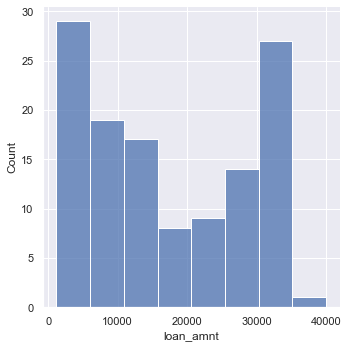

<Figure size 864x432 with 0 Axes>

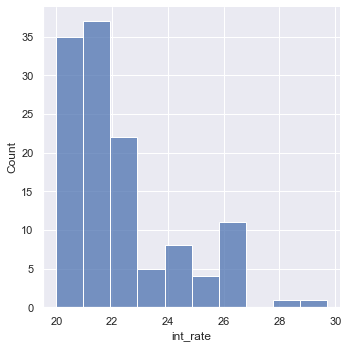

<Figure size 864x432 with 0 Axes>

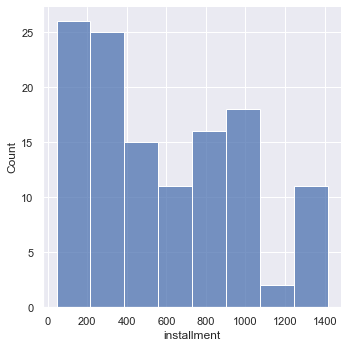

<Figure size 864x432 with 0 Axes>

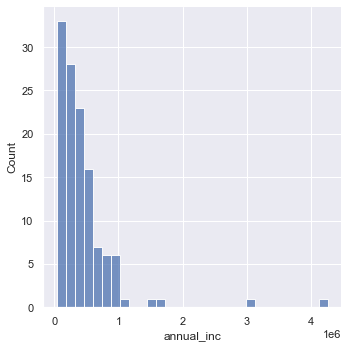

<Figure size 864x432 with 0 Axes>

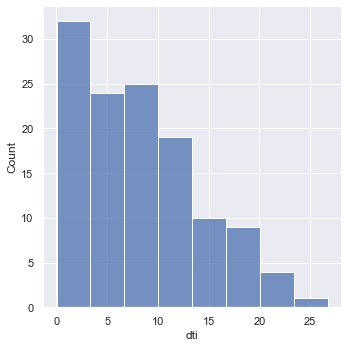

<Figure size 864x432 with 0 Axes>

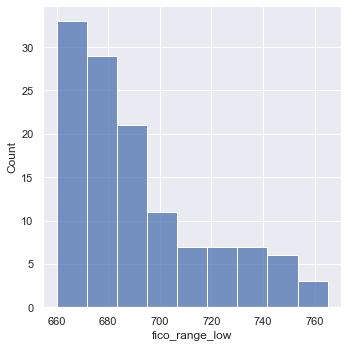

<Figure size 864x432 with 0 Axes>

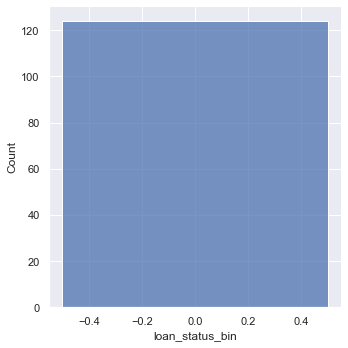

<Figure size 864x432 with 0 Axes>

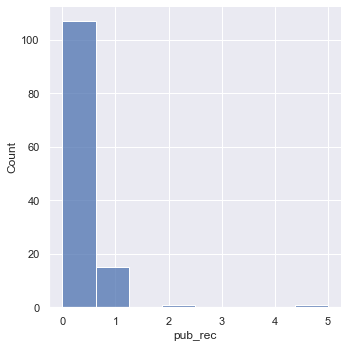

<Figure size 864x432 with 0 Axes>

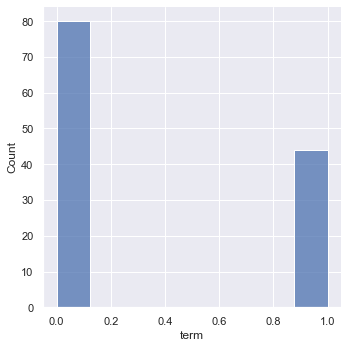

<Figure size 864x432 with 0 Axes>

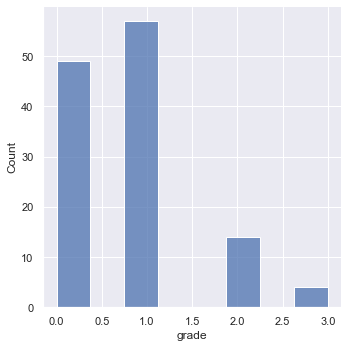

<Figure size 864x432 with 0 Axes>

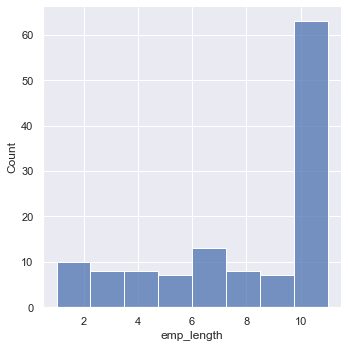

<Figure size 864x432 with 0 Axes>

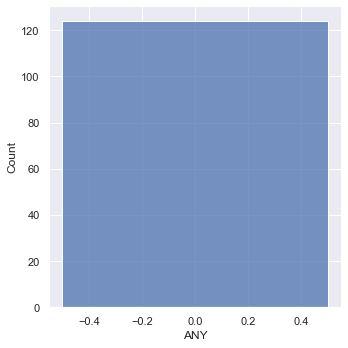

<Figure size 864x432 with 0 Axes>

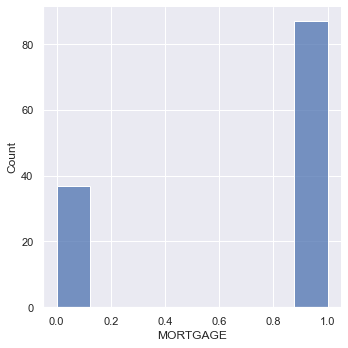

<Figure size 864x432 with 0 Axes>

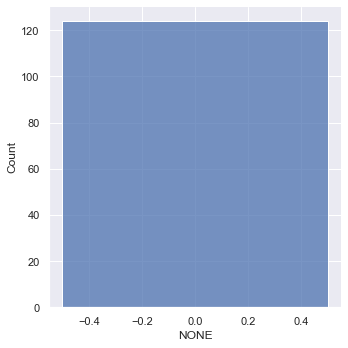

<Figure size 864x432 with 0 Axes>

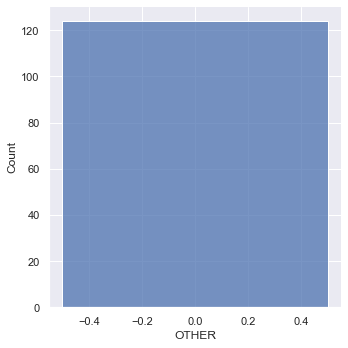

<Figure size 864x432 with 0 Axes>

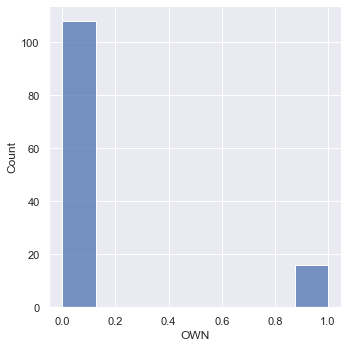

<Figure size 864x432 with 0 Axes>

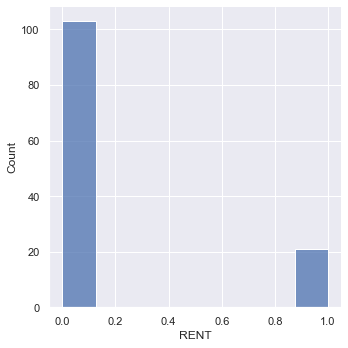

<Figure size 864x432 with 0 Axes>

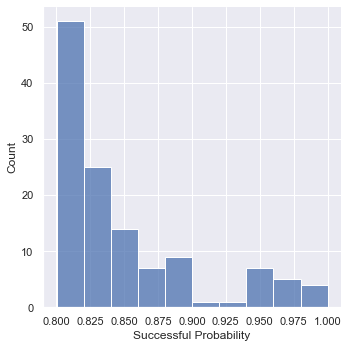

In [78]:
# create distplots
for column in study.columns:
    plt.figure()            
    sns.displot(study[column]);

In [32]:
#Do we drop all observations loan amount is greater than half of one's income? 

In [79]:
study.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,loan_status_bin,pub_rec,term,grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,Successful Probability
count,124.000000,124.000000,124.000000,1.240000e+02,124.000000,124.000000,124.0,124.000000,124.000000,124.000000,124.000000,124.0,124.000000,124.0,124.0,124.000000,124.000000,124.000000
mean,18041.129032,22.176210,584.719435,4.343025e+05,8.395726,691.370968,0.0,0.177419,0.354839,0.782258,8.088710,0.0,0.701613,0.0,0.0,0.129032,0.169355,0.849125
std,12007.723291,2.094516,379.971151,5.131883e+05,6.010151,26.758015,0.0,0.570955,0.480405,0.771025,3.390595,0.0,0.459406,0.0,0.0,0.336596,0.376587,0.053072
min,1200.000000,20.000000,44.790000,3.500000e+04,0.010000,660.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.800359
25%,6862.500000,20.390000,258.660000,1.695000e+05,3.157500,670.000000,0.0,0.000000,0.000000,0.000000,5.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.811507
50%,15000.000000,21.490000,538.005000,3.250000e+05,7.370000,682.500000,0.0,0.000000,0.000000,1.000000,10.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.826177
75%,30000.000000,22.810000,900.215000,5.287500e+05,12.052500,701.250000,0.0,0.000000,1.000000,1.000000,11.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.865016
max,40000.000000,29.690000,1415.780000,4.260016e+06,26.740000,765.000000,0.0,5.000000,1.000000,3.000000,11.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.999999


In [82]:
study[study['annual_inc'] < 40000]

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,loan_status_bin,pub_rec,term,grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,Successful Probability
48543,2500.0,20.2,93.17,35000.0,6.58,740.0,0.0,0.0,0,1,4,0,1,0,0,0,0,0.806657


In [83]:
original = pd.read_csv('../../Data/accepted.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [84]:
original.shape

(2260701, 151)

In [86]:
original.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,246

In [91]:
original[(original.int_rate==20.2) & (original.loan_amnt==2500) & (original.fico_range_low==740)]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1261782,18004818,NaN,2500.0,2500.0,2500.0,36 months,20.2,93.17,E,E3,deburring,3 years,MORTGAGE,35000.0,Verified,Jun-2014,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=18004818,NaN,other,Other,553xx,MN,6.58,0.0,Dec-2009,740.0,744.0,1.0,NaN,NaN,6.0,0.0,4423.0,42.5,11.0,f,0.0,0.0,1537.28,1537.28,734.73,476.48,0.0,326.07,58.6926,Jul-2015,93.17,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,126147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10400.0,NaN,NaN,NaN,7.0,21025.0,5480.0,44.1,0.0,0.0,36.0,53.0,4.0,4.0,1.0,4.0,NaN,4.0,NaN,0.0,2.0,3.0,3.0,3.0,3.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,5.0,100.0,0.0,0.0,0.0,141508.0,6558.0,9800.0,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#This one outliers is really strange. Can't figure out from data why they would default. 